Device: cuda
Loading UCI HAR Dataset from: C://Users/park9/CBAM_HAR/data
Loaded train data: X shape=(7352, 9, 128), y shape=(7352,)
Loaded test data: X shape=(2947, 9, 128), y shape=(2947,)
Train: 5881, Validation: 1471, Test: 2947

ABLATION STUDY START (Best-Val checkpoint → Final Test 1회)

Training: Baseline (Conv+Attn)
Config: {'use_cbam': False, 'use_crossformer': False, 'use_contrast': False, 'use_dim_reduction': False}
Parameters: 42,246
  Epoch [10/50] Loss: 0.1172 (CE: 0.1172, Contrast: 0.0000) | Val Acc: 0.9470 | Best Val: 0.9599 @ 8
  Epoch [20/50] Loss: 0.1090 (CE: 0.1090, Contrast: 0.0000) | Val Acc: 0.9551 | Best Val: 0.9606 @ 19
  Epoch [30/50] Loss: 0.0936 (CE: 0.0936, Contrast: 0.0000) | Val Acc: 0.9721 | Best Val: 0.9721 @ 30
  Epoch [40/50] Loss: 0.0826 (CE: 0.0826, Contrast: 0.0000) | Val Acc: 0.9660 | Best Val: 0.9721 @ 30
  Epoch [50/50] Loss: 0.0809 (CE: 0.0809, Contrast: 0.0000) | Val Acc: 0.9694 | Best Val: 0.9721 @ 30

✓ Baseline (Conv+Attn) Complete!
  Best Va

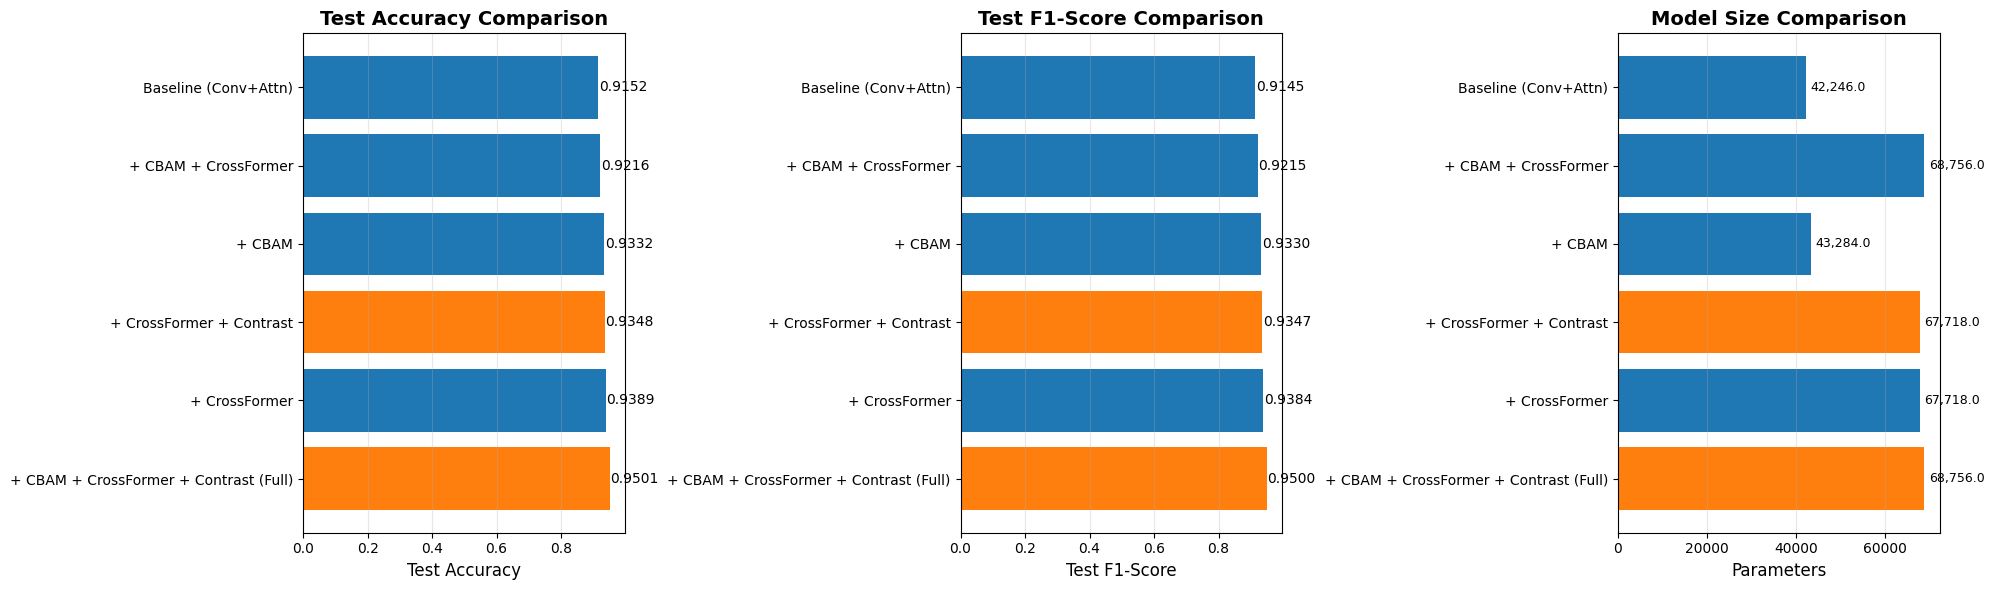

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os, copy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import random

def seed_everything(seed=42):
    """
    재현성을 위해 Python, NumPy, PyTorch의 Seed를 고정합니다.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    
    # cuDNN 설정 (재현성은 보장되나, 속도가 느려질 수 있음)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """
    DataLoader의 worker process를 위한 Seed 설정
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# =====================================================================
# 1. UCI HAR 데이터 로더
# =====================================================================
class UCIHARDataset(Dataset):
    def __init__(self, data_dir, train=True):
        """
        UCI HAR Dataset 로더
        data_dir: UCI HAR Dataset 폴더 경로
        train: True면 train 데이터, False면 test 데이터
        """
        subset = 'train' if train else 'test'

        # Inertial Signals 로드 (9개 센서)
        signals = []
        signal_types = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z'
        ]

        for signal in signal_types:
            filename = os.path.join(data_dir, subset, 'Inertial Signals',
                                f'{signal}_{subset}.txt')
            # 1. 파일을 'r' (읽기) 모드로 직접 엽니다.
            with open(filename, 'r') as f:
                # 2. np.loadtxt에 파일 이름 대신 파일 객체(f)를 전달합니다.
                data = np.loadtxt(f)
                
            signals.append(data)

        # (N, 9, 128) 형태로 변환
        self.X = np.stack(signals, axis=1)

        # 레이블 로드 (1~6 -> 0~5로 변환)
        label_file = os.path.join(data_dir, subset, f'y_{subset}.txt')
        # 1. 파일을 'r' (읽기) 모드로 직접 엽니다.
        with open(label_file, 'r') as f:
            # 2. np.loadtxt에 파일 객체(f)를 전달합니다.
            self.y = np.loadtxt(f, dtype=np.int32) - 1

        print(f"Loaded {subset} data: X shape={self.X.shape}, y shape={self.y.shape}")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]


# =====================================================================
# 2. 1D-CBAM (Channel + Temporal Attention)
# =====================================================================
class ChannelAttention1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, T)
        avg_out = self.fc(self.avg_pool(x).squeeze(-1))  # (B, C)
        max_out = self.fc(self.max_pool(x).squeeze(-1))  # (B, C)
        out = self.sigmoid(avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        return x * out


class TemporalAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)
        out = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        out = self.sigmoid(self.conv(out))  # (B, 1, T)
        return x * out


class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction)
        self.temporal_att = TemporalAttention1D(kernel_size)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x


# =====================================================================
# 3. Contrastive Prototype Loss
# =====================================================================
class ContrastivePrototypeLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, prototypes, labels):
        """
        Contrastive Loss between features and prototypes

        Args:
            features: (B, D) - 샘플 특징
            prototypes: (N_class, D) - 클래스별 프로토타입
            labels: (B,) - 레이블

        Returns:
            loss: contrastive loss
        """
        # L2 정규화
        features = F.normalize(features, dim=1)
        prototypes = F.normalize(prototypes, dim=1)

        # 유사도 계산 (B, N_class)
        logits = torch.matmul(features, prototypes.t()) / self.temperature

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)

        return loss


# =====================================================================
# 4. CrossFormer with Contrast Prototypes
# =====================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self, dim, n_prototypes=6, n_heads=4, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        # Learnable prototypes (L2 정규화 적용)
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))
        nn.init.xavier_uniform_(self.prototypes)

        # Cross-Attention: Input(Q) x Prototypes(K, V)
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)

        # Self-Attention
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)

        # FFN
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

        # Prototype projection (contrastive learning용)
        self.proto_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x, return_proto_features=False):
        # x: (B, T, C)
        B, T, C = x.shape

        # L2 normalize prototypes for contrastive learning
        normalized_prototypes = F.normalize(self.prototypes, dim=1)

        # 1. Cross-Attention with normalized prototypes
        prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)  # (B, n_proto, C)
        x_norm = self.norm1(x)
        cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
        x = x + cross_out

        # 2. Self-Attention
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out

        # 3. FFN
        x = x + self.mlp(self.norm3(x))

        # Prototype features for contrastive loss
        if return_proto_features:
            # Global average pooling
            proto_features = x.mean(dim=1)  # (B, C)
            proto_features = self.proto_proj(proto_features)  # projection
            return x, proto_features, attn_weights

        return x


# =====================================================================
# 5. 메인 모델: CrossFormer + 1D-CBAM + Contrast Prototype
# =====================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    def __init__(self,
                 in_channels=9,
                 seq_len=128,
                 embed_dim=64,
                 reduced_dim=32,
                 n_classes=6,
                 n_prototypes=6,
                 n_heads=4,
                 dropout=0.1,
                 # Ablation 옵션
                 use_cbam=True,
                 use_crossformer=True,
                 use_contrast=True,
                 use_dim_reduction=True):
        super().__init__()

        self.in_channels = in_channels
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        # 1. Input Embedding (1D Conv)
        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=7, padding=3),
            nn.BatchNorm1d(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # 2. CBAM (선택적)
        if self.use_cbam:
            self.cbam = CBAM1D(embed_dim, reduction=8, kernel_size=7)

        # 3. 차원 축소 (선택적)
        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        # 4. CrossFormer Block (선택적)
        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim,
                n_prototypes=n_prototypes,
                n_heads=n_heads,
                mlp_ratio=2.0,
                dropout=dropout
            )
        else:
            # CrossFormer 없이 Self-Attention만 사용
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim,
                nhead=n_heads,
                dim_feedforward=int(working_dim * 2),
                dropout=dropout,
                batch_first=True
            )

        # 5. 차원 복원 (선택적)
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        # 6. Global Pooling + Classifier
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes)
        )

        # 7. Contrastive Loss (선택적)
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=0.07)

    def forward(self, x, labels=None, return_contrast_loss=False):
        # x: (B, C, T) = (B, 9, 128)

        # 1. Embedding
        x = self.embedding(x)  # (B, embed_dim, T)

        # 2. CBAM (선택적)
        if self.use_cbam:
            x = self.cbam(x)

        # 3. Reshape for Transformer
        x = x.transpose(1, 2)  # (B, T, embed_dim)

        # 4. 차원 축소 (선택적)
        if self.use_dim_reduction:
            x = self.dim_reduce(x)

        # 5. CrossFormer 또는 Self-Attention
        proto_features = None
        attn_weights = None

        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, attn_weights = self.crossformer(x, return_proto_features=True)
            else:
                x = self.crossformer(x, return_proto_features=False)
        else:
            x = self.self_attn(x)

        # 6. 차원 복원 (선택적)
        if self.use_dim_reduction:
            x = self.dim_restore(x)

        # 7. Pooling + Classification
        x = x.transpose(1, 2)  # (B, embed_dim, T)
        x = self.pool(x).squeeze(-1)  # (B, embed_dim)
        logits = self.classifier(x)  # (B, n_classes)

        # Contrastive Loss 계산
        if return_contrast_loss and self.use_contrast and proto_features is not None and labels is not None:
            contrast_loss = self.contrast_loss(
                proto_features,
                self.crossformer.prototypes,
                labels
            )
            return logits, contrast_loss

        return logits


# =====================================================================
# 6. 학습 및 평가 (Contrastive Loss 포함)
# =====================================================================
def train_epoch(model, dataloader, criterion, optimizer, device, use_contrast=True, contrast_weight=0.5):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_contrast_loss = 0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss + contrast_weight * contrast_loss
            total_contrast_loss += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    avg_contrast_loss = total_contrast_loss / len(dataloader) if total_contrast_loss > 0 else 0
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1, all_preds, all_labels


# =====================================================================
# 7. Ablation Study 실행
# =====================================================================
def run_ablation_study(train_loader, val_loader, test_loader, device, epochs=50):
    """
    Ablation Study 실행 (Contrastive Prototype 포함)
    공정성을 위해: 학습 중엔 val만 보고, 루프 종료 후 best-val 체크포인트로 test 1회 평가
    """
    ablation_configs = {
        'Baseline (Conv+Attn)': {
            'use_cbam': False, 'use_crossformer': False, 'use_contrast': False, 'use_dim_reduction': False
        },
        '+ CBAM': {
            'use_cbam': True, 'use_crossformer': False, 'use_contrast': False, 'use_dim_reduction': False
        },
        '+ CrossFormer': {
            'use_cbam': False, 'use_crossformer': True, 'use_contrast': False, 'use_dim_reduction': False
        },
        '+ CrossFormer + Contrast': {
            'use_cbam': False, 'use_crossformer': True, 'use_contrast': True, 'use_dim_reduction': False
        },
        '+ CBAM + CrossFormer': {
            'use_cbam': True, 'use_crossformer': True, 'use_contrast': False, 'use_dim_reduction': False
        },
        '+ CBAM + CrossFormer + Contrast (Full)': {
            'use_cbam': True, 'use_crossformer': True, 'use_contrast': True, 'use_dim_reduction': False
        }
    }

    results = defaultdict(dict)

    print("\n" + "="*80)
    print("ABLATION STUDY START (Best-Val checkpoint → Final Test 1회)")
    print("="*80)

    for config_name, config_params in ablation_configs.items():
        print(f"\n{'='*80}")
        print(f"Training: {config_name}")
        print(f"Config: {config_params}")
        print(f"{'='*80}")

        # 1) 모델/옵티마
        model = ContrastCrossFormerCBAM_HAR(
            in_channels=9, seq_len=128, embed_dim=64, reduced_dim=32,
            n_classes=6, n_prototypes=6, n_heads=4, dropout=0.1, **config_params
        ).to(device)

        total_params = sum(p.numel() for p in model.parameters())
        print(f"Parameters: {total_params:,}")

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # 2) 베스트-검증 트래킹
        best_val_acc = -1.0
        best_epoch = -1
        best_state = None

        # 3) 학습 루프 (⚠️ test는 선택 기준에 사용하지 않음)
        for epoch in range(epochs):
            train_loss, train_ce, train_contrast, train_acc, train_f1 = train_epoch(
                model, train_loader, criterion, optimizer, device,
                use_contrast=config_params['use_contrast'], contrast_weight=0.2
            )
            val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

            # (옵션) 모니터링용 test를 찍고 싶다면 아래 주석 해제 (결과는 기록/선택에 사용 금지)
            # _t_loss, _t_acc, _t_f1, _, _ = evaluate(model, test_loader, criterion, device)

            scheduler.step()

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1
                best_state = copy.deepcopy(model.state_dict())

            if (epoch + 1) % 10 == 0:
                print(f"  Epoch [{epoch+1:2d}/{epochs}] "
                      f"Loss: {train_loss:.4f} "
                      f"(CE: {train_ce:.4f}, Contrast: {train_contrast:.4f}) | "
                      f"Val Acc: {val_acc:.4f} | Best Val: {best_val_acc:.4f} @ {best_epoch}")

        # 4) 루프 종료 후: 베스트-검증 체크포인트 로드 → 최종 test 1회
        assert best_state is not None, "best_state가 None입니다. 학습 루프 내부 갱신 로직을 확인하세요."
        model.load_state_dict(best_state)
        test_loss, test_acc, test_f1, _, _ = evaluate(model, test_loader, criterion, device)

        # 5) 결과 저장/출력
        results[config_name] = {
            'params': total_params,
            'best_val_acc': best_val_acc,
            'best_val_epoch': best_epoch,
            'best_test_acc': test_acc,
            'best_test_f1': test_f1
        }

        print(f"\n✓ {config_name} Complete!")
        print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
        print(f"  Final Test (Best-VAL ckpt): Acc={test_acc:.4f} | F1={test_f1:.4f}")

    return results

def plot_ablation_results(results):
    """
    Ablation 결과 시각화
    """
    # DataFrame 생성
    df = pd.DataFrame(results).T
    df = df.sort_values('best_test_acc', ascending=False)

    # 1. 성능 비교 바 차트
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Test Accuracy
    colors = ['#1f77b4' if 'Contrast' not in idx else '#ff7f0e' for idx in df.index]
    axes[0].barh(df.index, df['best_test_acc'], color=colors)
    axes[0].set_xlabel('Test Accuracy', fontsize=12)
    axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df['best_test_acc']):
        axes[0].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10)

    # Test F1-Score
    axes[1].barh(df.index, df['best_test_f1'], color=colors)
    axes[1].set_xlabel('Test F1-Score', fontsize=12)
    axes[1].set_title('Test F1-Score Comparison', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df['best_test_f1']):
        axes[1].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10)

    # Parameters
    axes[2].barh(df.index, df['params'], color=colors)
    axes[2].set_xlabel('Parameters', fontsize=12)
    axes[2].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df['params']):
        axes[2].text(v + 1000, i, f'{v:,}', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig('ablation_results_contrast.png', dpi=150, bbox_inches='tight')
    print("\nAblation results saved to 'ablation_results_contrast.png'")

    # 2. 결과 테이블 출력
    print("\n" + "="*80)
    print("ABLATION STUDY RESULTS (with Contrastive Prototype)")
    print("="*80)
    print(df.to_string())

    # CSV 저장
    df.to_csv('ablation_results_contrast.csv')
    print("\nResults saved to 'ablation_results_contrast.csv'")

    return df


# =====================================================================
# 8. 메인 실행
# =====================================================================
def main():
    # 하이퍼파라미터
    DATA_DIR = 'C://Users/park9/CBAM_HAR/data'
    BATCH_SIZE = 128
    EPOCHS = 50  # 30 → 50으로 증가
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42

    seed_everything(SEED)

    print(f"Device: {DEVICE}")
    print(f"Loading UCI HAR Dataset from: {DATA_DIR}")

    # 데이터 로드
    train_full_dataset = UCIHARDataset(DATA_DIR, train=True)
    test_dataset = UCIHARDataset(DATA_DIR, train=False)

    # Train을 Train/Validation으로 분할 (80:20)
    train_size = int(0.8 * len(train_full_dataset))
    val_size = len(train_full_dataset) - train_size
    train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size],
                                               generator=torch.Generator().manual_seed(SEED))

    print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    g = torch.Generator()
    g.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              worker_init_fn=seed_worker, generator=g)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            worker_init_fn=seed_worker)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             worker_init_fn=seed_worker)

    # Ablation Study 실행
    results = run_ablation_study(train_loader, val_loader, test_loader, DEVICE, epochs=EPOCHS)

    # 결과 시각화
    df_results = plot_ablation_results(results)

    print("\n" + "="*80)
    print("ABLATION STUDY COMPLETED!")
    print("="*80)


if __name__ == '__main__':
    main()